In [29]:
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
from utils import Array

In [30]:
target  = pd.read_pickle('files/Target.pkl')
desired = pd.read_pickle('files/Desired.pkl')
display(target.head())
display(desired.head())

,time,s2,s1
790,0.00,"{'ax': 0.1783421941299244, 'ay': 0.09260905795...","{'ax': 0.1783421941299244, 'ay': 0.09260905795..."
791,0.00,"{'ax': 0.8134219711045458, 'ay': 0.42239158732...","{'ax': 0.8134219711045458, 'ay': 0.42239158732..."
792,0.02,"{'ax': 1.880247119104515, 'ay': 0.973287208666...","{'ax': 1.8811126117435046, 'ay': 0.97323912908..."
793,0.04,"{'ax': 3.1671693029767765, 'ay': 1.61861328550...","{'ax': 3.1693858251863367, 'ay': 1.61824975495..."
794,0.04,"{'ax': 4.515188667568089, 'ay': 2.257755268012...","{'ax': 4.516362568239357, 'ay': 2.256593591657..."


,pitch,roll,yaw,wx,wy,wz,ax,ay,az,time
790,26.60,-49.98,307.93,722.0,-2628.0,-106.0,221.0,174.0,265.0,0.00
791,27.80,-55.47,306.93,716.0,-2374.0,-239.0,301.0,160.0,237.0,0.00
792,28.77,-60.41,305.73,704.0,-2019.0,-36.0,299.0,224.0,184.0,0.02
793,29.37,-64.83,304.39,558.0,-1732.0,74.0,340.0,213.0,115.0,0.04
794,29.37,-64.83,304.39,558.0,-1732.0,74.0,340.0,213.0,115.0,0.04


# ANÁLISE

In [31]:
sensor = 's1'
key    = 'ax'

time = target.time.values
yTarget  = np.array([s[key] for s in target[sensor]])
yDesired = np.array(desired[key])

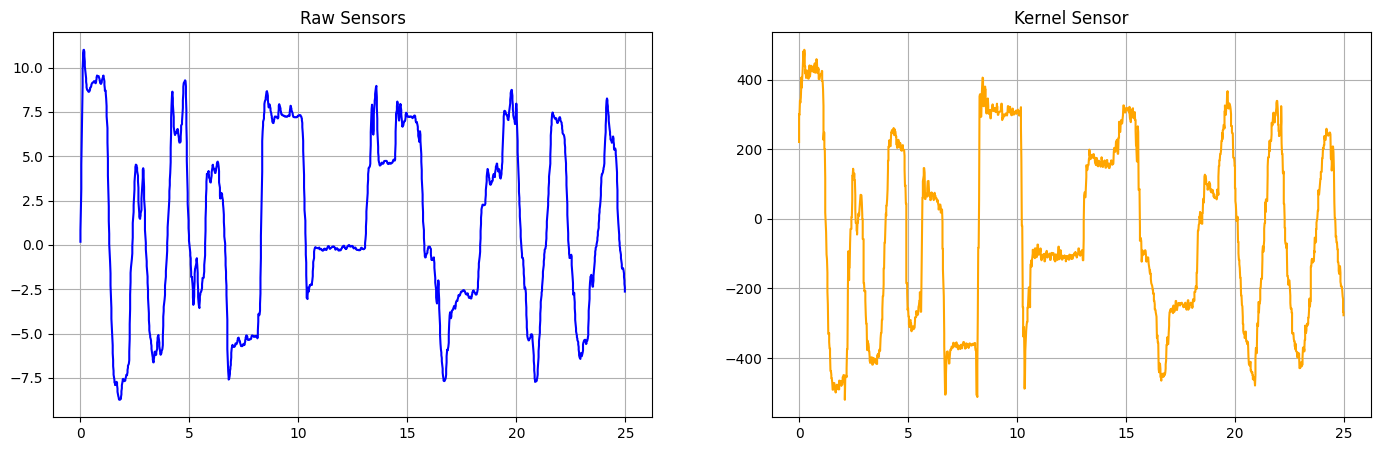

In [32]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.plot(time, yTarget, color='blue')
plt.title('Raw Sensors')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(time, yDesired, color='orange')
plt.title('Kernel Sensor')
plt.grid()

- Comparação normalizada com erro relacionado à distancia entre os pontos

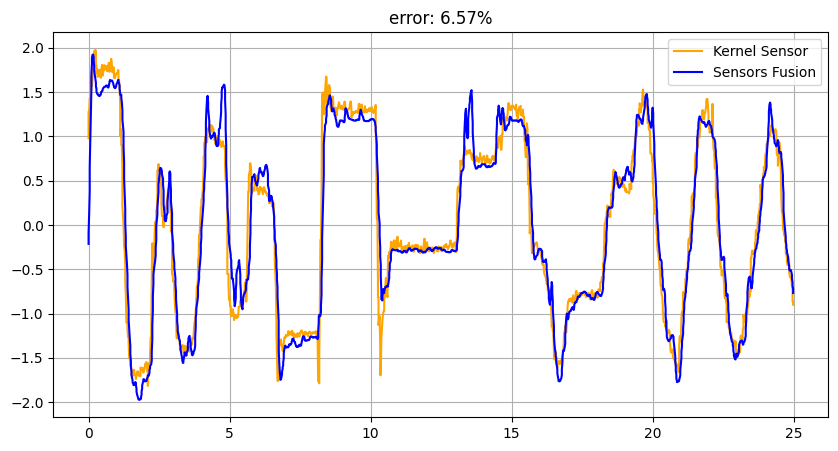

In [33]:
def normalize(data):
    return np.array(data - np.mean(data))/np.std(data)

def compare(data1, data2):
    data1 = normalize(data1)
    data2 = normalize(data2)
    score = wasserstein_distance(data1, data2)
    return data1, data2, score


d, t, score = compare(yDesired, yTarget)
plt.figure(figsize=(10, 5))
plt.plot(time, d, color='orange', label='Kernel Sensor')
plt.plot(time, t, color='blue',  label='Sensors Fusion')
plt.title(f'error: {score*100:.2f}%')
plt.legend(), plt.grid()
plt.show()

# ALGORITMO DE FUSÃO
    ### FUSÃO POR KALMAN

| Parâmetro | Tipo / Unidade          | Intuição prática (“tradução”)                                  | Como ajustar / escolher                                          |
|-----------|-------------------------|----------------------------------------------------------------|------------------------------------------------------------------|
| x0        | Escalar (mesma unidade) | Palpite inicial do valor real                                  | Use a 1ª leitura do sensor mais confiável ou um valor médio      |
| P0        | Escalar ≥ 0 (unidade²)  | Variância inicial → quão incerto você está sobre x0            | Grande ⇒ confia pouco no palpite; Pequeno ⇒ confia muito         |
| Q         | Escalar ≥ 0 (unidade²)  | Ruído do modelo → permite que o estado mude entre amostras      | Aumente para reagir mais rápido; diminua para suavizar           |
| R         | Matriz 3 × 3 (diag)     | Ruído de medição de cada sensor (σ² na diagonal)                | Coloque σ² de cada sensor; maior σ² ⇒ peso menor na fusão        |

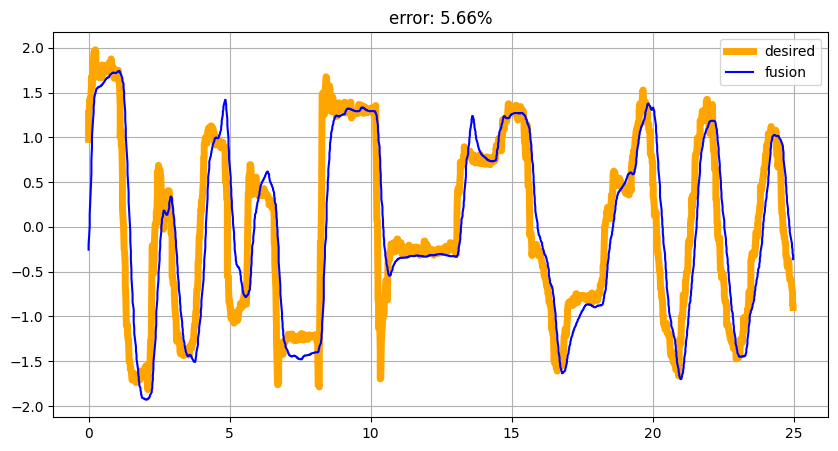

In [34]:
class KalmanFusion:
    def __init__(self, x0=0.0, P0=1e3, Q=1e-2, R=(1.0,)):
        self.x = float(x0)
        self.P = float(P0)
        self.Q = float(Q)

        if isinstance(R, (int, float)):
            self.R = (float(R), )
        else:
            self.R = tuple(float(r) for r in R)

    def predict(self):
        self.P += self.Q

    def update(self, z):
        self.predict()

        if isinstance(z, (int, float)):
            z = (float(z), )
        else:
            z = tuple(float(zi) for zi in z)

        for zi, Ri in zip(z, self.R):
            S = self.P + Ri        # variância da inovação
            K = self.P / S         # ganho de Kalman (escalar)
            y = zi - self.x        # inovação
            self.x += K * y
            self.P = (1.0 - K) * self.P

        return self.x

    def apply(self, data):
        return [kalman.update(values) for values in data]

kalman = KalmanFusion(x0=0, P0=3.5, Q=0.01, R=(4.0, 3.5))
yModel = kalman.apply([(row.s1[key], row.s2[key]) for i, row in target.iterrows()])

d, y, score = compare(yDesired, yModel)
plt.figure(figsize=(10, 5))
plt.plot(time, d, color='orange', label='desired', linewidth=5)
plt.plot(time, y, color='blue',  label='fusion')
plt.title(f'error: {score*100:.2f}%')
plt.legend(), plt.grid()
plt.show()

# COMPARANDO DADOS

<Figure size 1700x1000 with 0 Axes>

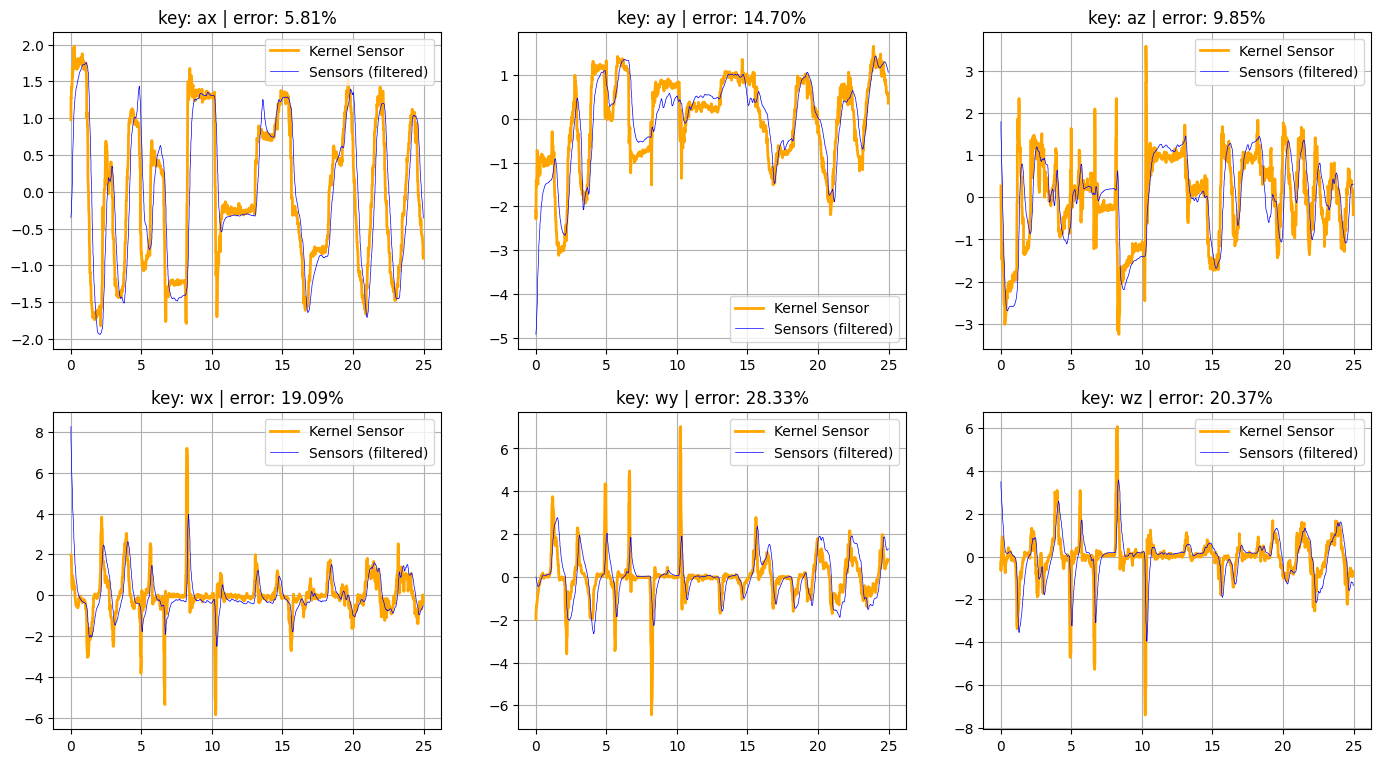

In [35]:
plt.figure(figsize=(17, 10))

values = {
    'ax': KalmanFusion(x0=0, P0=3.5, Q=0.01, R=(4.0, 3.5)).apply([(row.s1['ax'], row.s2['ax']) for i, row in target.iterrows()]),
    'ay': KalmanFusion(x0=0, P0=3.5, Q=0.01, R=(4.0, 3.5)).apply([(row.s1['ay'], row.s2['ay']) for i, row in target.iterrows()]),
    'az': KalmanFusion(x0=0, P0=3.5, Q=0.01, R=(4.0, 3.5)).apply([(row.s1['az'], row.s2['az']) for i, row in target.iterrows()]),

    'wx': KalmanFusion(x0=0, P0=3.5, Q=0.01, R=(4.0, 3.5)).apply([(row.s1['wx'], row.s2['wx']) for i, row in target.iterrows()]),
    'wy': KalmanFusion(x0=0, P0=3.5, Q=0.01, R=(4.0, 3.5)).apply([(row.s1['wy'], row.s2['wy']) for i, row in target.iterrows()]),
    'wz': KalmanFusion(x0=0, P0=3.5, Q=0.01, R=(4.0, 3.5)).apply([(row.s1['wz'], row.s2['wz']) for i, row in target.iterrows()]),
}

plt.figure(figsize=(17, 14))
index = 0

for key, data in values.items():
    d, t, score = compare(desired[key], data)
    index = index + 1

    plt.subplot(3, 3, index)
    plt.plot(desired.time, d, color='orange', label='Kernel Sensor', linewidth=2)
    plt.plot(desired.time, t, color='blue',  label='Sensors (filtered)', linewidth=.5)
    plt.title(f'key: {key} | error: {score*100:.2f}%')
    plt.legend(), plt.grid()

# SALVANDO

In [36]:
values['time'] = time
target = pd.DataFrame(values)
target.head()

,ax,ay,az,wx,wy,wz,time
0,-0.337944,-0.343994,7.239196,3.731570,-0.062499,1.539075,0.00
1,-0.256701,-0.289915,6.724431,3.475130,-0.080483,1.431842,0.00
2,-0.105883,-0.200782,6.241739,3.244595,-0.124124,1.333691,0.02
3,0.125146,-0.072412,5.787254,3.037949,-0.192071,1.243422,0.04
4,0.434959,0.091973,5.353423,2.852055,-0.274701,1.159130,0.04


In [37]:
target.to_pickle('../D - Orientation/files/Target.pkl')
desired.to_pickle('../D - Orientation/files/Desired.pkl')